# ABC calibration of $I_\text{CaL}$ in Nygren model to unified dataset.

In [5]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

In [7]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used for unified dataset calibration:
 - Steady-state activation [Li1997]
 - Activation time constant [Li1997]
 - Steady-state inactivation [Li1997]
 - Inactivation time constant (fast+slow) [Li1997]
 - Recovery time constant (fast+slow) [Li1997]

In [8]:
from experiments.ical_li import (li_act_and_tau, # combines steady-state activation and time constant
                                 li_inact_1000,
                                 li_inact_kin_80,
                                 li_recov)

In [9]:
modelfile = 'models/nygren_ical.mmt'

Plot steady-state and time constant functions of original model

In [10]:
from ionchannelABC.visualization import plot_variables

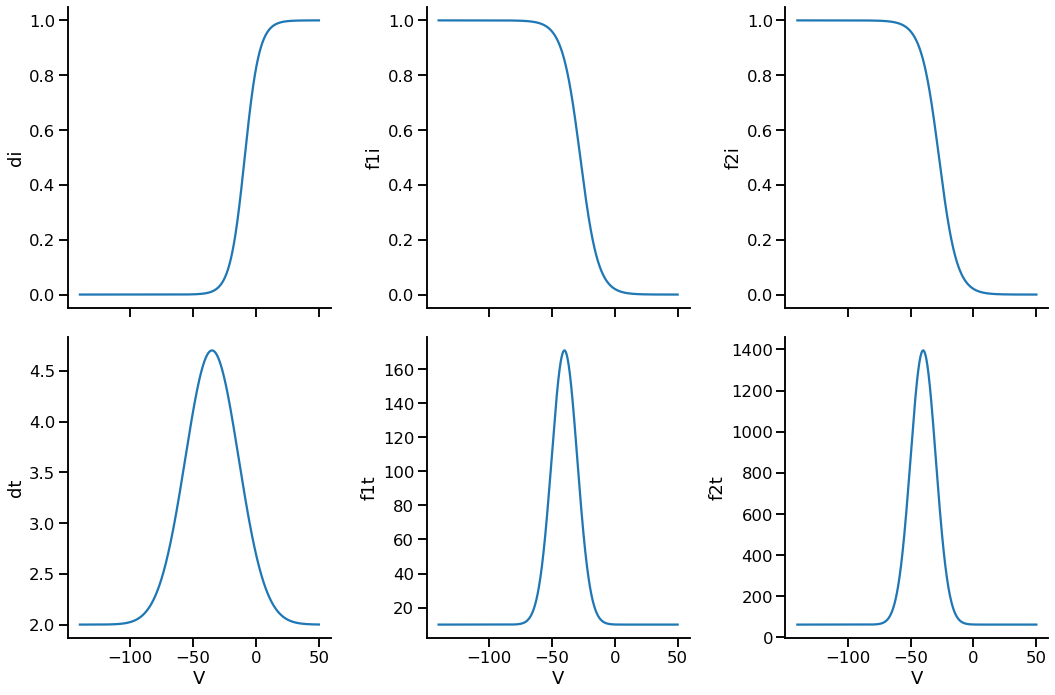

In [11]:
sns.set_context('talk')

V = np.arange(-140, 50, 0.01)

nyg_par_map = {'di': 'ical.d_inf',
            'f1i': 'ical.f_inf',
            'f2i': 'ical.f_inf',
            'dt': 'ical.tau_d',
            'f1t': 'ical.tau_f_1',
            'f2t': 'ical.tau_f_2'}

f, ax = plot_variables(V, nyg_par_map, 'models/nygren_ical.mmt', figshape=(3,2))

# Activation gate ($d$) calibration

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [12]:
observations, model, summary_statistics = setup(modelfile,
                                                li_act_and_tau)

In [13]:
assert len(observations)==len(summary_statistics(model({})))

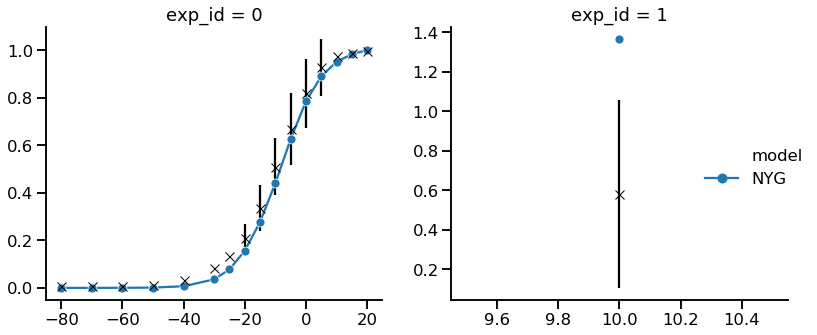

In [14]:
g = plot_sim_results(modelfile,
                     li_act_and_tau)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [15]:
limits = {'ical.p1': (-100, 100),
          'ical.p2': (0, 50),
          'log_ical.p3': (-7, 3),
          'ical.p4': (-100, 100),
          'ical.p5': (0, 50),
          'log_ical.p6': (-7, 3)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [17]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [13]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "nygren_ical_dgate_unified.db"))

In [14]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

Test theoretical number of particles for approximately 2 particles per dimension in the initial sampling of the parameter hyperspace.

In [15]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 64 particles


Initialise ABCSMC (see pyABC documentation for further details).

IonChannelDistance calculates the weighting applied to each datapoint based on the experimental variance.

In [16]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.2287454676498424, '1': 1.2287454676498424, '2': 1.2287454676498424, '3': 1.2287454676498424, '4': 1.2287454676498424, '5': 1.2287454676498424, '6': 1.2287454676498424, '7': 1.0293830767146164, '8': 0.6283247351374927, '9': 0.5133263088125923, '10': 0.4040167399213943, '11': 0.41888315675832816, '12': 0.5146915383573082, '13': 1.2287454676498424, '14': 1.2287454676498424, '15': 1.2287454676498424, '16': 1.2039197677998432}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [17]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [18]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-18 09:52:37.719386, end_time=None)>


Run calibration with stopping criterion of particle 1\% acceptance rate.

In [19]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 3852
DEBUG:Epsilon:new eps, t=1, eps=2.551139210627562
INFO:ABC:t:1 eps:2.551139210627562
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 8011
DEBUG:Epsilon:new eps, t=2, eps=1.5010936714315752
INFO:ABC:t:2 eps:1.5010936714315752
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 12588
DEBUG:Epsilon:new eps, t=3, eps=1.2691794246600032
INFO:ABC:t:3 eps:1.2691794246600032
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 17866
DEBUG:Epsilon:new eps, t=4, eps=1.0801458314591663
INFO:ABC:t:4 eps:1.0801458314591663
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 24716
DEBUG:Epsilon:new eps, t=5, eps=0.85395199300

## Analysis of results

In [16]:
history = History('sqlite:///results/nygren/ical/unified/nygren_ical_dgate_unified.db')

In [18]:
history.all_runs()

[<ABCSMC(id=1, start_time=2019-10-18 09:52:37.719386, end_time=2019-10-18 11:12:07.102511)>]

In [19]:
df, w = history.get_distribution(m=0)

In [20]:
df.describe()

name,ical.p1,ical.p2,ical.p4,ical.p5,log_ical.p3,log_ical.p6
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,9.155574,7.440593,-9.667851,25.107911,-3.860552,-3.370706
std,1.687823,0.715094,58.114323,13.860362,1.813276,0.693737
min,0.569566,5.978839,-99.910401,0.053268,-6.991878,-6.982718
25%,9.029113,6.996519,-59.245228,12.715218,-5.276181,-3.150881
50%,9.583629,7.293097,-25.051834,25.080482,-3.953773,-3.131242
75%,10.058233,7.640347,45.338142,37.124560,-2.702818,-3.121220
max,13.763338,10.639110,99.865786,49.984638,2.660139,-2.882964


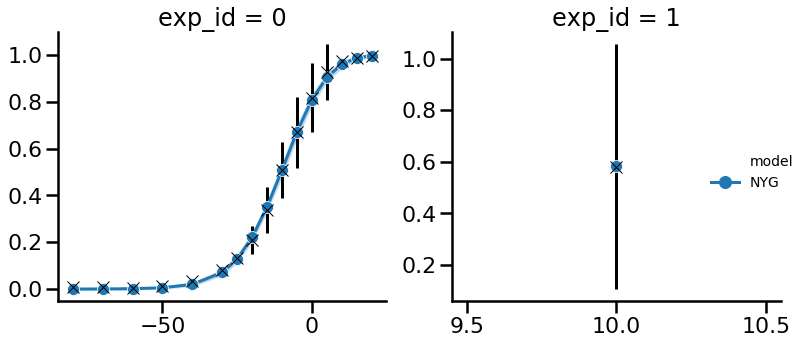

In [21]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     li_act_and_tau,
                     df=df, w=w)

plt.tight_layout()

In [23]:
import pandas as pd
N = 100

nyg_par_samples = df.sample(n=N, weights=w, replace=True)
nyg_par_samples = nyg_par_samples.set_index([pd.Index(range(N))])
nyg_par_samples = nyg_par_samples.to_dict(orient='records')

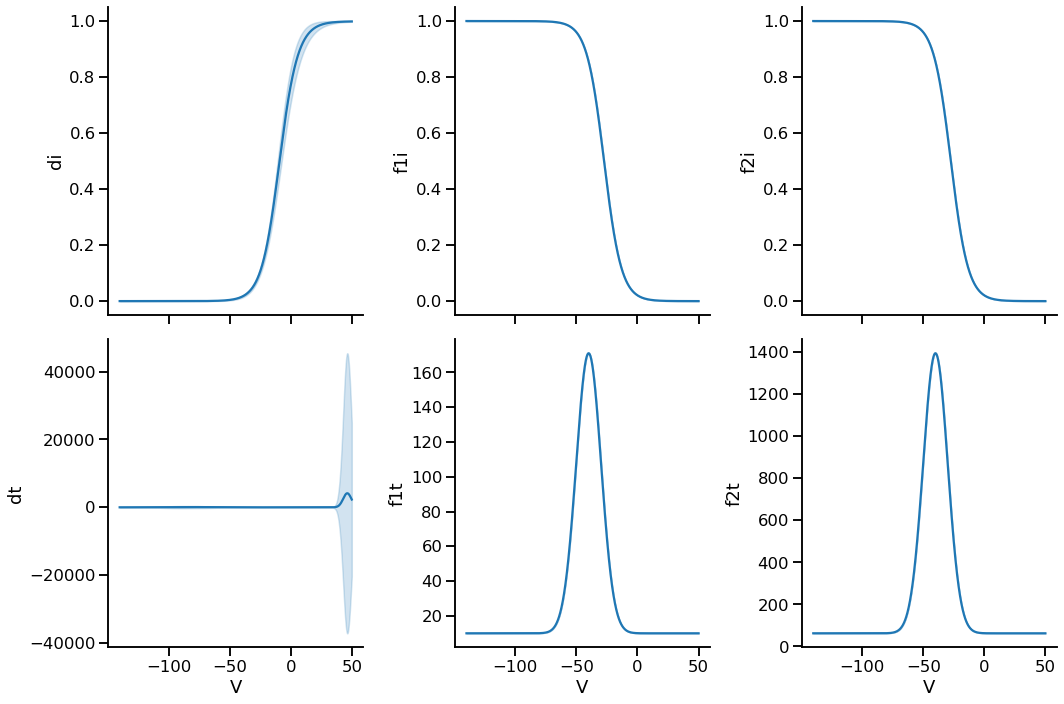

In [24]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, nyg_par_map, 
                       'models/nygren_ical.mmt', 
                       [nyg_par_samples],
                       figshape=(3,2))

In [25]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [26]:
m,_,_ = myokit.load(modelfile)

In [27]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

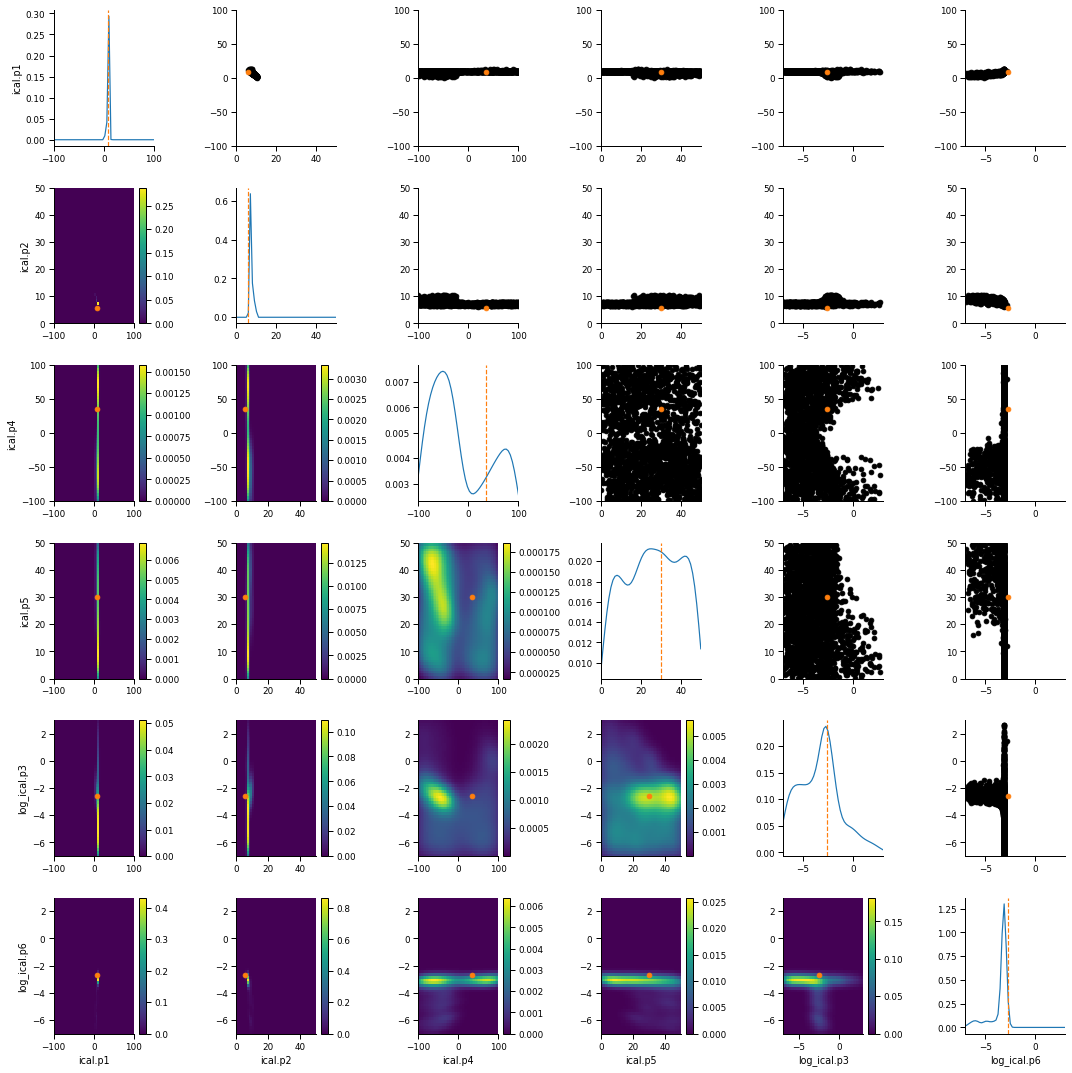

In [29]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)